# Week 3 — Tire Life Prediction (ML Project #1)

This notebook builds machine learning models to predict tire degradation behavior.
Models: Linear Regression → Random Forest → (optional) LSTM.

Data source: Cleaned laps from Week 2.
Goal: Predict lap time or remaining tire life.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import joblib  # for saving models

# project paths
project_path = "/content/drive/MyDrive/F1-Strategy-Lab"
data_path = project_path + "/data"

In [4]:
race_year = 2024
race_name = "bahrain_grand_prix"

laps_file = f"{data_path}/{race_year}/{race_name}/laps_{race_year}_{race_name}.csv"
laps = pd.read_csv(laps_file)
print(laps.head())

                     Time Driver  DriverNumber                 LapTime  \
0  0 days 01:01:37.489000    VER             1  0 days 00:01:37.284000   
1  0 days 01:03:13.785000    VER             1  0 days 00:01:36.296000   
2  0 days 01:04:50.538000    VER             1  0 days 00:01:36.753000   
3  0 days 01:06:27.185000    VER             1  0 days 00:01:36.647000   
4  0 days 01:08:04.358000    VER             1  0 days 00:01:37.173000   

   LapNumber  Stint PitOutTime PitInTime             Sector1Time  \
0        1.0    1.0        NaN       NaN                     NaN   
1        2.0    1.0        NaN       NaN  0 days 00:00:30.916000   
2        3.0    1.0        NaN       NaN  0 days 00:00:30.999000   
3        4.0    1.0        NaN       NaN  0 days 00:00:30.931000   
4        5.0    1.0        NaN       NaN  0 days 00:00:31.255000   

              Sector2Time  ... FreshTyre             Team  \
0  0 days 00:00:41.266000  ...     False  Red Bull Racing   
1  0 days 00:00:41.66100

In [5]:
def prepare_laps(df):
    # Convert LapTime to seconds
    def to_seconds(laptime_str):
        if isinstance(laptime_str, float) or laptime_str is None:
            return np.nan
        parts = str(laptime_str).split()[-1]
        m, s = parts.split(":")[1:]
        minutes = int(parts.split(":")[1])
        seconds = float(s)
        return minutes * 60 + seconds

    df["LapTimeSeconds"] = df["LapTime"].apply(to_seconds)

    # Remove pit laps
    if {"PitOutTime", "PitInTime"}.issubset(df.columns):
        df = df[df["PitOutTime"].isna() & df["PitInTime"].isna()]

    # Remove nan and very slow laps
    df = df[df["LapTimeSeconds"].notna()]
    median_time = df["LapTimeSeconds"].median()
    df = df[df["LapTimeSeconds"] < median_time * 1.15]

    # Fix TyreLife if missing
    if "TyreLife" not in df.columns or df["TyreLife"].isna().all():
        df["TyreLife"] = df.groupby(["Driver", "Stint"]).cumcount() + 1

    return df.reset_index(drop=True)


In [6]:
clean_laps = prepare_laps(laps)
clean_laps.head()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.266000,...,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,NaN,False,False,97.284
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaN,NaN,0 days 00:00:30.916000,0 days 00:00:41.661000,...,Red Bull Racing,0 days 01:01:37.489000,2024-03-02 15:05:19.920,1,1.0,False,NaN,False,True,96.296
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaN,NaN,0 days 00:00:30.999000,0 days 00:00:41.966000,...,Red Bull Racing,0 days 01:03:13.785000,2024-03-02 15:06:56.216,1,1.0,False,NaN,False,True,96.753
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaN,NaN,0 days 00:00:30.931000,0 days 00:00:41.892000,...,Red Bull Racing,0 days 01:04:50.538000,2024-03-02 15:08:32.969,1,1.0,False,NaN,False,True,96.647
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaN,NaN,0 days 00:00:31.255000,0 days 00:00:42.056000,...,Red Bull Racing,0 days 01:06:27.185000,2024-03-02 15:10:09.616,1,1.0,False,NaN,False,True,97.173


In [7]:
import os
import joblib  # already imported but just in case

models_path = project_path + "/models"
os.makedirs(models_path, exist_ok=True)

print("Models will be saved to:", models_path)


Models will be saved to: /content/drive/MyDrive/F1-Strategy-Lab/models


### Model 1 — Linear Regression (Baseline)

The goal of this model is to create a simple baseline for predicting lap time using tire age (`TyreLife`).

**Why Linear Regression?**  
It provides a quick way to estimate how strongly lap time depends on tire wear.  
A positive coefficient indicates rising lap times (degradation).

**Results (VER – HARD):**
- **MAE ≈ 0.12 s** — small average error  
- **R² < 0** — linear model does not capture enough variance  
- **Degradation rate ≈ +0.068 s per lap**  
- **Fresh tire pace ≈ 94.84 s**

**Interpretation:**  
Verstappen’s degradation on hard tires is very low and almost flat, which the model confirms.  
However, tire behavior is not perfectly linear, and external factors (fuel burn-off, track evolution, traffic) add noise.  
This motivates using more expressive models next, such as Random Forest.


In [ ]:
driver_code = "VER"
compound = "HARD"

subset = clean_laps[
    (clean_laps["Driver"] == driver_code) &
    (clean_laps["Compound"] == compound)
].copy()

subset[["Driver", "Compound", "TyreLife", "LapTimeSeconds"]].head()
print("Number of laps in subset:", len(subset))


Number of laps in subset: 18


In [ ]:
# Feature: tyre age in laps
X = subset[["TyreLife"]]

# Target: lap time in seconds
y = subset["LapTimeSeconds"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(14, 4)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression (driver:", driver_code, "compound:", compound, ")")
print("  MAE:", round(mae, 3), "seconds")
print("  R² :", round(r2, 3))
print("  Coeff (s per lap of tyre age):", lin_reg.coef_[0])
print("  Intercept (fresh tyre pace):  ", lin_reg.intercept_)


Linear Regression (driver: VER compound: HARD )
  MAE: 0.126 seconds
  R² : -0.142
  Coeff (s per lap of tyre age): 0.06773871626219075
  Intercept (fresh tyre pace):   94.84383102744387


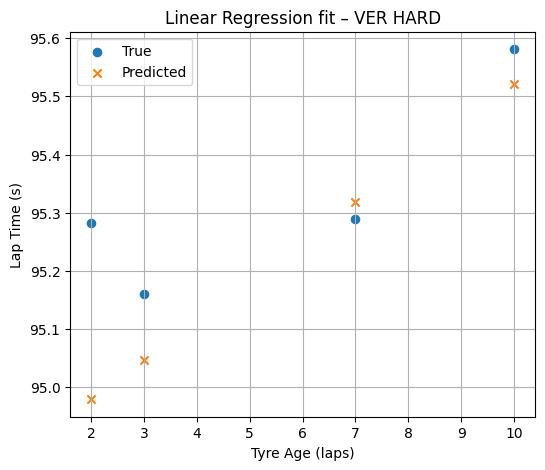

In [ ]:
plt.figure(figsize=(6, 5))

plt.scatter(X_test["TyreLife"], y_test, label="True", s=35)
plt.scatter(X_test["TyreLife"], y_pred, label="Predicted", s=35, marker="x")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"Linear Regression fit – {driver_code} {compound}")
plt.grid(True)
plt.legend()
plt.show()


In [2]:
model_filename = f"linreg_{race_year}_{race_name}_{driver_code}_{compound}.pkl"
model_path = f"{models_path}/{model_filename}"

joblib.dump(lin_reg, model_path)

print("Saved model to:", model_path)


NameError: name 'race_year' is not defined

### Model Behavior: LEC vs VER (HARD Compound)

Training the same Linear Regression model on Leclerc’s hard-tire stint reveals:

- **Much higher MAE (~1.0s)**  
- **More negative R²**  
- **Unstable degradation coefficient**

This indicates that Ferrari’s lap times are more variable and harder to predict with a simple linear model.  
Red Bull’s data, in contrast, produces tighter prediction error and more stable degradation trends.

**Strategic Meaning:**  
Cars with consistent long-run behavior (like the RB20) allow more accurate modeling and more reliable race strategy simulations.  
Cars with fluctuating degradation (like Ferrari in Bahrain) produce noisier data, making pit window prediction harder.


In [8]:
driver_code = "LEC"
compound = "HARD"

subset = clean_laps[
    (clean_laps["Driver"] == driver_code) &
    (clean_laps["Compound"] == compound)
].copy()

subset[["Driver", "Compound", "TyreLife", "LapTimeSeconds"]].head()
print("Number of laps in subset:", len(subset))


Number of laps in subset: 43


In [9]:
# Feature: tyre age in laps
X = subset[["TyreLife"]]

# Target: lap time in seconds
y = subset["LapTimeSeconds"]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(34, 9)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression (driver:", driver_code, "compound:", compound, ")")
print("  MAE:", round(mae, 3), "seconds")
print("  R² :", round(r2, 3))
print("  Coeff (s per lap of tyre age):", lin_reg.coef_[0])
print("  Intercept (fresh tyre pace):  ", lin_reg.intercept_)


Linear Regression (driver: LEC compound: HARD )
  MAE: 0.956 seconds
  R² : -0.283
  Coeff (s per lap of tyre age): 0.04130681722423529
  Intercept (fresh tyre pace):   95.59395188337407


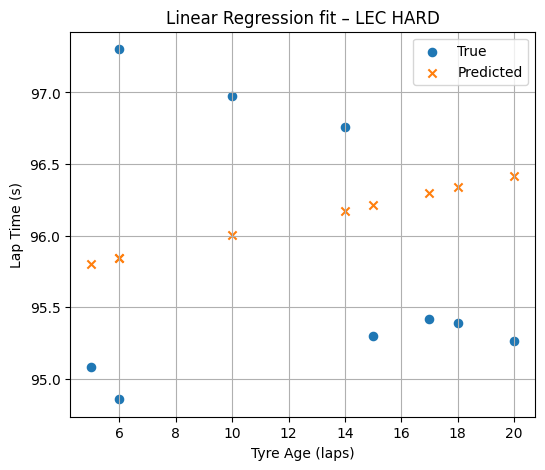

In [12]:
plt.figure(figsize=(6, 5))

plt.scatter(X_test["TyreLife"], y_test, label="True", s=35)
plt.scatter(X_test["TyreLife"], y_pred, label="Predicted", s=35, marker="x")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"Linear Regression fit – {driver_code} {compound}")
plt.grid(True)
plt.legend()
plt.show()


In [13]:
model_filename = f"linreg_{race_year}_{race_name}_{driver_code}_{compound}.pkl"
model_path = f"{models_path}/{model_filename}"

joblib.dump(lin_reg, model_path)

print("Saved model to:", model_path)

Saved model to: /content/drive/MyDrive/F1-Strategy-Lab/models/linreg_2024_bahrain_grand_prix_LEC_HARD.pkl


⭐ Random Forest Regression

In [14]:
from sklearn.ensemble import RandomForestRegressor


In [15]:
driver_code = "VER"   # change to VER if you want
compound = "HARD"

subset = clean_laps[
    (clean_laps["Driver"] == driver_code) &
    (clean_laps["Compound"] == compound)
].copy()

print("Number of laps:", len(subset))
subset.head()


Number of laps: 18


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
16,0 days 01:31:05.101000,VER,1,0 days 00:01:35.283000,19.0,2.0,NaN,NaN,0 days 00:00:30.628000,0 days 00:00:41.162000,...,Red Bull Racing,0 days 01:29:29.818000,2024-03-02 15:33:12.249,1,1.0,False,NaN,False,True,95.283
17,0 days 01:32:40.261000,VER,1,0 days 00:01:35.160000,20.0,2.0,NaN,NaN,0 days 00:00:30.585000,0 days 00:00:41.100000,...,Red Bull Racing,0 days 01:31:05.101000,2024-03-02 15:34:47.532,1,1.0,False,NaN,False,True,95.160
18,0 days 01:34:15.577000,VER,1,0 days 00:01:35.316000,21.0,2.0,NaN,NaN,0 days 00:00:30.576000,0 days 00:00:41.240000,...,Red Bull Racing,0 days 01:32:40.261000,2024-03-02 15:36:22.692,1,1.0,False,NaN,False,True,95.316
19,0 days 01:35:50.781000,VER,1,0 days 00:01:35.204000,22.0,2.0,NaN,NaN,0 days 00:00:30.560000,0 days 00:00:41.142000,...,Red Bull Racing,0 days 01:34:15.577000,2024-03-02 15:37:58.008,1,1.0,False,NaN,False,True,95.204
20,0 days 01:37:25.997000,VER,1,0 days 00:01:35.216000,23.0,2.0,NaN,NaN,0 days 00:00:30.553000,0 days 00:00:41.145000,...,Red Bull Racing,0 days 01:35:50.781000,2024-03-02 15:39:33.212,1,1.0,False,NaN,False,True,95.216


In [16]:
X = subset[["TyreLife"]]
y = subset["LapTimeSeconds"]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [19]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest (driver:", driver_code, "compound:", compound, ")")
print("  MAE:", round(mae, 3))
print("  R² :", round(r2, 3))


Random Forest (driver: VER compound: HARD )
  MAE: 0.108
  R² : 0.093


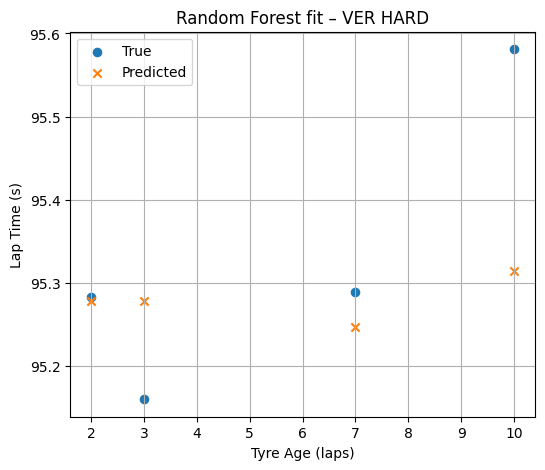

In [20]:
plt.figure(figsize=(6, 5))

plt.scatter(X_test["TyreLife"], y_test, label="True", s=35)
plt.scatter(X_test["TyreLife"], y_pred, label="Predicted", s=35, marker="x")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"Random Forest fit – {driver_code} {compound}")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
model_filename = f"rf_{race_year}_{race_name}_{driver_code}_{compound}.pkl"
model_path = f"{models_path}/{model_filename}"

joblib.dump(rf, model_path)

print("Saved Random Forest model to:", model_path)

Saved Random Forest model to: /content/drive/MyDrive/F1-Strategy-Lab/models/rf_2024_bahrain_grand_prix_VER_HARD.pkl


In [ ]:
driver_code = "LEC"   # change to VER if you want
compound = "HARD"

subset = clean_laps[
    (clean_laps["Driver"] == driver_code) &
    (clean_laps["Compound"] == compound)
].copy()

print("Number of laps:", len(subset))
subset.head()


Number of laps: 43


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
169,0 days 01:21:35.526000,LEC,16,0 days 00:01:36.432000,13.0,2.0,NaN,NaN,0 days 00:00:30.580000,0 days 00:00:42.173000,...,Ferrari,0 days 01:19:59.094000,2024-03-02 15:23:41.525,1,9.0,False,NaN,False,True,96.432
170,0 days 01:23:12.282000,LEC,16,0 days 00:01:36.756000,14.0,2.0,NaN,NaN,0 days 00:00:30.787000,0 days 00:00:42.232000,...,Ferrari,0 days 01:21:35.526000,2024-03-02 15:25:17.957,1,8.0,False,NaN,False,True,96.756
171,0 days 01:24:49.095000,LEC,16,0 days 00:01:36.813000,15.0,2.0,NaN,NaN,0 days 00:00:30.831000,0 days 00:00:42.256000,...,Ferrari,0 days 01:23:12.282000,2024-03-02 15:26:54.713,1,6.0,False,NaN,False,True,96.813
172,0 days 01:26:25.768000,LEC,16,0 days 00:01:36.673000,16.0,2.0,NaN,NaN,0 days 00:00:30.606000,0 days 00:00:42.320000,...,Ferrari,0 days 01:24:49.095000,2024-03-02 15:28:31.526,1,4.0,False,NaN,False,True,96.673
173,0 days 01:28:03.070000,LEC,16,0 days 00:01:37.302000,17.0,2.0,NaN,NaN,0 days 00:00:31.109000,0 days 00:00:42.332000,...,Ferrari,0 days 01:26:25.768000,2024-03-02 15:30:08.199,1,5.0,False,NaN,False,True,97.302


In [ ]:
X = subset[["TyreLife"]]
y = subset["LapTimeSeconds"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest (driver:", driver_code, "compound:", compound, ")")
print("  MAE:", round(mae, 3))
print("  R² :", round(r2, 3))


Random Forest (driver: LEC compound: HARD )
  MAE: 1.295
  R² : -1.297


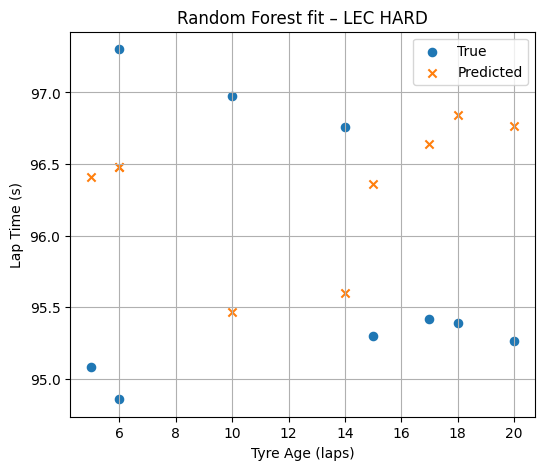

In [ ]:
plt.figure(figsize=(6, 5))

plt.scatter(X_test["TyreLife"], y_test, label="True", s=35)
plt.scatter(X_test["TyreLife"], y_pred, label="Predicted", s=35, marker="x")

plt.xlabel("Tyre Age (laps)")
plt.ylabel("Lap Time (s)")
plt.title(f"Random Forest fit – {driver_code} {compound}")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
model_filename = f"rf_{race_year}_{race_name}_{driver_code}_{compound}.pkl"
model_path = f"{models_path}/{model_filename}"

joblib.dump(rf, model_path)

print("Saved Random Forest model to:", model_path)


Saved Random Forest model to: /content/drive/MyDrive/F1-Strategy-Lab/models/rf_2024_bahrain_grand_prix_LEC_HARD.pkl


### Why Random Forest Fails on LEC HARD

The Random Forest model performs significantly worse on Leclerc's hard-tire stint than on Verstappen’s.
This reflects the real behavior of Ferrari's car in Bahrain:

- Higher lap-time volatility  
- Harder-to-model degradation trends  
- Pace that fluctuates due to thermal sensitivity and setup instability  

Random Forest attempts to fit non-linear patterns, but when the underlying signal is noisy, the model ends up fitting noise rather than true degradation.  
This produces:

- Higher MAE  
- Highly negative R²  
- Scattered predictions  

**Conclusion:** Ferrari's degradation on hard tires is not only worse — it is also significantly less *predictable*.  
This is a real competitive disadvantage during long stints.
